In [1]:
# lets make NB distributions of expression

# testing ideas
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import numpy as np
import random

import anndata as ad
import pandas as pd
from scipy.sparse import coo_matrix, csc_matrix

In [2]:
# how many samples to generate
patients_to_generate = 1000
genes_to_generate = 1000

genes_to_generate = genes_to_generate - 50 # we will be adding the PAM50 using pre-defined parameters

theta_pull_dist = 1

# balance between batches
# do not set to 0 or 1 (will have to fix this)
batch_balance = 0.5

# other parameters
# whether or not to draw distributions when generating simulated genes
# note that there's no limitations to this; if you're creating 10000 genes it'll draw 10000 plots
draw_NB_data = False

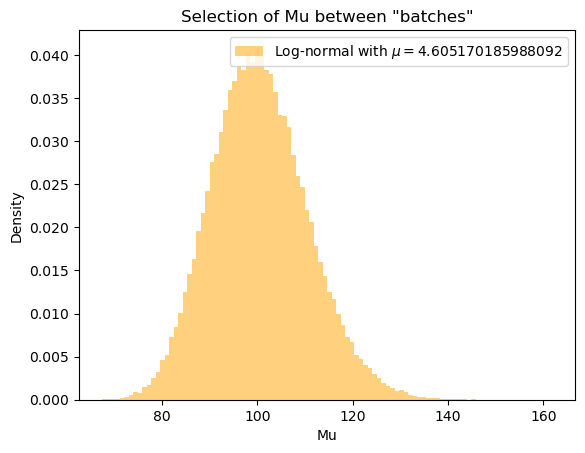

In [3]:
# In this version of the code, I want to create a distribution to "pull" our NB Mu parameters from
# we discussed log-normal
mu_pull_dist = np.log(100)

sigma = 0.1  # standard deviation of the logarithm of the variable (example value)

# Generate a sample from the log-normal distribution
# Generate samples for both distributions
sample_size = patients_to_generate*100 # multiplication ensures a varied number of possible values
samples = np.random.lognormal(mean=mu_pull_dist, sigma=sigma, size=sample_size)

samples_rounded = np.round(samples, 6)

# Plotting the samples
plt.hist(samples_rounded, bins=100, density=True, alpha=0.5, color='orange', label=f'Log-normal with $\mu={mu_pull_dist}$')
plt.title('Selection of Mu between "batches"')
plt.xlabel('Mu')
plt.ylabel('Density')
# plt.xscale('log')
plt.legend()
plt.show()

In [4]:
# Container for simulated data
train_data, valid_data, gene_names = [], [], []
gene_basal_p, gene_her2_p, gene_luma_p, gene_lumb_p, gene_normal_p = [], [], [], [], []
gene_basal_r, gene_her2_r, gene_luma_r, gene_lumb_r, gene_normal_r = [], [], [], [], []
mu_batch1, mu_batch2 = [], []

# we have to sample from both log normals outside of the loop so that we can ensure replacement
sampled_mus = np.random.choice(samples_rounded, size=genes_to_generate, replace=False)


# Bernouli trial idea didn't work out
# This way, all samples will get the same mu, not a partial amount
samples_indices = np.random.binomial(n=1, p=batch_balance, size=patients_to_generate)

for i in range(genes_to_generate):
    # so we compute the p and n parameters for each batch using their respective Mu/thetas
    mu_batch = sampled_mus[i]
    var_batch = mu_batch + (mu_batch**2 / theta_pull_dist)
    r_batch = mu_batch**2 / (var_batch - mu_batch)
    p_batch = r_batch / (r_batch + mu_batch)

    # we then sample M (patients) values from both NBs
    #counts_batch1 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch_train = nbinom.rvs(r_batch, p_batch, size=patients_to_generate)

    # and we use the Bernouli to select from which NB distribution do we take values from
    #selected_data_train = np.where(samples_indices == 0, counts_batch1, counts_batch2)
    selected_data_train = counts_batch_train
    
    # append it to a list of gene expression values
    train_data.append(selected_data_train)  

    # repeat for validation
    counts_batch_val = nbinom.rvs(r_batch, p_batch, size=patients_to_generate)

    # and we use the Bernouli to select from which NB distribution do we take values from
    #selected_data_val = np.where(samples_indices == 0, counts_batch3, counts_batch4)
    selected_data_val = counts_batch_val

    # append it to a list of gene expression values
    valid_data.append(selected_data_val)  

    # Saving p,r (will be the same since these genes are unaffected by subtype)
    gene_basal_p.append(p_batch)
    gene_her2_p.append(p_batch)
    gene_luma_p.append(p_batch)
    gene_lumb_p.append(p_batch)
    gene_normal_p.append(p_batch)

    gene_basal_r.append(r_batch)
    gene_her2_r.append(r_batch)
    gene_luma_r.append(r_batch)
    gene_lumb_r.append(r_batch)
    gene_normal_r.append(r_batch)


    # Creating a unique gene name
    gene_name = "Gene_" + str(i + 1)
    gene_names.append(gene_name)

    # draw expression selected out if desired
    title = "Expression for Gene " + str(i + 1)

    if (draw_NB_data is True):
        plt.hist(selected_data_train, bins=50, color="blue")
        plt.xlabel("Expression")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.show()

        


In [5]:
# add PAM50 genes
pam50_path = "/data/lab_vm/refined/preffect/6_dispersion/9_Exploring_NB_In_PAM50/our_dcis.NB_PAM50.Median.Trim_3.Subtype.RoundFix.csv"

df = pd.read_csv(pam50_path)

df_pivot = df.pivot_table(index='Gene', columns='Subtype', values=['p','r'], aggfunc='first')
df_pivot.reset_index(inplace=True)
df_pivot.columns = [' '.join(col).strip() for col in df_pivot.columns.values]

# selection of sample subtype
subtype_prob = [0.2, 0.2, 0.2, 0.2, 0.2]
selected_indices_train = np.random.choice(a=[0, 1, 2, 3, 4], p=subtype_prob, size=patients_to_generate)
selected_indices_valid = np.random.choice(a=[0, 1, 2, 3, 4], p=subtype_prob, size=patients_to_generate)

# Looping over each row
for index, row in df_pivot.iterrows():
    p_basal = row['p Basal']
    p_her2 = row['p Her2']
    p_luma = row['p LumA']
    p_lumb = row['p LumB']
    p_normal = row['p Normal']

    r_basal = row['r Basal']    
    r_her2 = row['r Her2']
    r_luma = row['r LumA']
    r_lumb = row['r LumB']
    r_normal = row['r Normal']

    # we then sample M (patients) values from both NBs
    counts_train_basal = nbinom.rvs(r_basal, p_basal, size=patients_to_generate)
    counts_train_her2 = nbinom.rvs(r_her2, p_her2, size=patients_to_generate)
    counts_train_luma = nbinom.rvs(r_luma, p_luma, size=patients_to_generate)
    counts_train_lumb = nbinom.rvs(r_lumb, p_lumb, size=patients_to_generate)
    counts_train_normal = nbinom.rvs(r_normal, p_normal, size=patients_to_generate)
    
    # how do we handle batch in this case?
    # and we use the Bernouli to select from which NB distribution do we take values from
    
    counts_stack = np.stack([counts_train_basal, counts_train_her2, counts_train_luma, counts_train_lumb, counts_train_normal])
    selected_data_train = counts_stack[selected_indices_train, np.arange(patients_to_generate)]

    # append it to a list of gene expression values
    train_data.append(selected_data_train)  

    # repeat for validation
    counts_val_basal = nbinom.rvs(r_basal, p_basal, size=patients_to_generate)
    counts_val_her2 = nbinom.rvs(r_her2, p_her2, size=patients_to_generate)
    counts_val_luma = nbinom.rvs(r_luma, p_luma, size=patients_to_generate)
    counts_val_lumb = nbinom.rvs(r_lumb, p_lumb, size=patients_to_generate)
    counts_val_normal = nbinom.rvs(r_normal, p_normal, size=patients_to_generate)
    
    counts_stack = np.stack([counts_val_basal, counts_val_her2, counts_val_luma, counts_val_lumb, counts_val_normal])
    selected_data_val = counts_stack[selected_indices_valid, np.arange(patients_to_generate)]

    
    # append it to a list of gene expression values
    valid_data.append(selected_data_val)  

    # Saving Mus/Thetas; to be placed in the AnnData 'var' table
    gene_basal_p.append(p_basal)
    gene_her2_p.append(p_her2)
    gene_luma_p.append(p_luma)
    gene_lumb_p.append(p_lumb)
    gene_normal_p.append(p_normal)

    gene_basal_r.append(r_basal)
    gene_her2_r.append(r_her2)
    gene_luma_r.append(r_luma)
    gene_lumb_r.append(r_lumb)
    gene_normal_r.append(r_normal)


    # Creating a unique gene name
    gene_name = "Gene_" + str(i + 1)
    gene_names.append(row['Gene'])



In [ ]:
# if we want, this forcing edges in gene/gene | sample/sample index by copying over its neighboring entry
counts_in_anndata_orientation_train = np.transpose(np.array(train_data))
counts_in_anndata_orientation_valid = np.transpose(np.array(valid_data))

# samples = True means we create a sample/sample edge, otherwise gene/gene

adata_train = ad.AnnData(X=counts_in_anndata_orientation_train, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# add batch of 1s
adata_train.obs['batch'] = np.zeros(adata_train.obs.shape[0], dtype=int)

# add subtype information
subtype_order = ['basal', 'her2', 'luma', 'lumb', 'normal']
mapped_subtypes = [subtype_order[index] for index in selected_indices_train]
adata_train.obs['subtype'] = mapped_subtypes

# add gene names to var
adata_train.var['gene'] = gene_names
adata_train.var['p_basal'] = gene_basal_p
adata_train.var['r_basal'] = gene_basal_r
adata_train.var['p_her2'] = gene_her2_p
adata_train.var['r_her2'] = gene_her2_r
adata_train.var['p_luma'] = gene_luma_p
adata_train.var['r_luma'] = gene_luma_r
adata_train.var['p_lumb'] = gene_lumb_p
adata_train.var['r_lumb'] = gene_lumb_r
adata_train.var['p_normal'] = gene_normal_p
adata_train.var['r_normal'] = gene_normal_r


# I still need to generate the gene_gene and sample_sample adjacency matrix!
# gene/gene
df = pd.DataFrame(adata_train.X, columns=adata_train.var_names)

# sample/sample adj matrix
#df_transposed = pd.DataFrame(adata_train.X.T, columns=adata_train.obs_names, index=adata_train.var_names)
#correlation_matrix_samples = df_transposed.corr()
#sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
#print(sample_sample_adj)
#np.fill_diagonal(sample_sample_adj.values, 1)

# create our own sample_sample_adj
subtype_values = adata_train.obs['subtype'].values
sample_sample_adj = (subtype_values[:, None] == subtype_values[None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_train.obsm['sample_sample_adj'] = sample_sample_adj_coo


# and lets save the data
folder_path = '/path/to/output/'

file_path = folder_path + 'sim_simple_w_layers.sim_subtype.M_' + str(patients_to_generate) + '_N_' + str(genes_to_generate + 50) + '_th_' + str(theta_pull_dist) + '_batch_bal_' + str(batch_balance) + '.RoundFix.train.tau_1.h5ad'

# Save the AnnData object
adata_train.write(file_path)


     batch subtype
0        0    luma
1        0    her2
2        0    luma
3        0    lumb
4        0    luma
..     ...     ...
995      0    luma
996      0  normal
997      0  normal
998      0   basal
999      0    lumb

[1000 rows x 2 columns]
[[1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


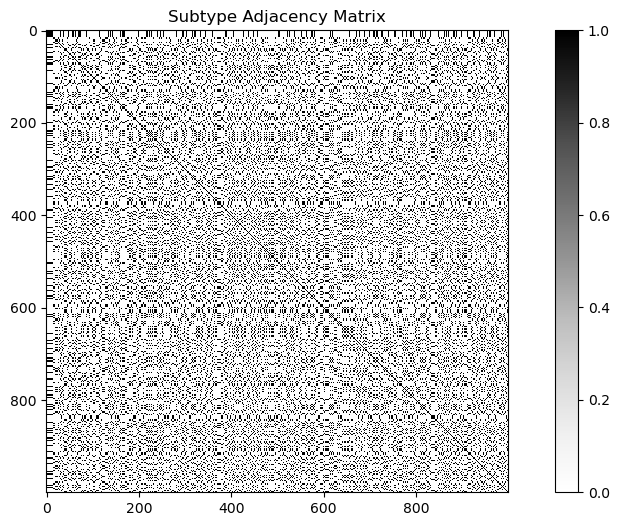

In [7]:
print(adata_train.obs)
print(sample_sample_adj)

plt.figure(figsize=(12, 6))
plt.imshow(sample_sample_adj, cmap='Greys', interpolation='none')
plt.title('Subtype Adjacency Matrix')
plt.colorbar()
plt.show()

In [ ]:

adata_valid = ad.AnnData(X=counts_in_anndata_orientation_valid, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
# add subtype information
adata_valid.obs['batch'] = np.zeros(adata_valid.obs.shape[0], dtype=int)
mapped_subtypes = [subtype_order[index] for index in selected_indices_valid]
adata_valid.obs['subtype'] = mapped_subtypes


# add gene names to var
adata_valid.var['gene'] = gene_names
adata_valid.var['p_basal'] = gene_basal_p
adata_valid.var['r_basal'] = gene_basal_r
adata_valid.var['p_her2'] = gene_her2_p
adata_valid.var['r_her2'] = gene_her2_r
adata_valid.var['p_luma'] = gene_luma_p
adata_valid.var['r_luma'] = gene_luma_r
adata_valid.var['p_lumb'] = gene_lumb_p
adata_valid.var['r_lumb'] = gene_lumb_r
adata_valid.var['p_normal'] = gene_normal_p
adata_valid.var['r_normal'] = gene_normal_r

# sample/sample
subtype_values = adata_valid.obs['subtype'].values
sample_sample_adj = (subtype_values[:, None] == subtype_values[None, :]).astype(int)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_valid.obsm['sample_sample_adj'] = sample_sample_adj_coo

file_path = folder_path + 'sim_simple_w_layers.sim_subtype.M_' + str(patients_to_generate) + '_N_' + str(genes_to_generate + 50) + '_th_' + str(theta_pull_dist) + '_batch_bal_' + str(batch_balance) + '.RoundFix.test.tau_1.h5ad'

# Save the AnnData object
adata_valid.write(file_path)



/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [9]:
# checking to see how many sample-sample "edges" were created in this run
print("# Sample Edges", np.sum(np.sum(sample_sample_adj)))
print(adata_train.var)

# Sample Edges 202092
            gene   p_basal   r_basal    p_her2    r_her2    p_luma    r_luma  \
Gene_1    Gene_1  0.010937  1.000000  0.010937  1.000000  0.010937  1.000000   
Gene_2    Gene_2  0.009603  1.000000  0.009603  1.000000  0.009603  1.000000   
Gene_3    Gene_3  0.010357  1.000000  0.010357  1.000000  0.010357  1.000000   
Gene_4    Gene_4  0.011236  1.000000  0.011236  1.000000  0.011236  1.000000   
Gene_5    Gene_5  0.008365  1.000000  0.008365  1.000000  0.008365  1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
SLC39A6  SLC39A6  0.000140  0.971367  0.000095  0.574769  0.000069  2.146075   
TMEM45B  TMEM45B  0.004174  0.736948  0.000838  0.501144  0.001625  0.548008   
TYMS        TYMS  0.001334  0.413814  0.006296  1.229600  0.006513  0.822088   
UBE2C      UBE2C  0.001228  0.487343  0.002149  0.602707  0.002584  0.270621   
UBE2T      UBE2T  0.003082  0.461581  0.005148  0.812018  0.004266  0.307940   

           p_lumb

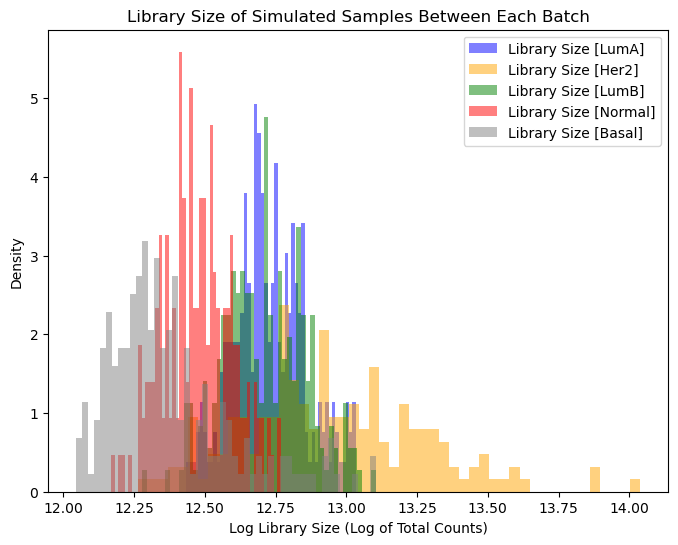

In [10]:
# draw library size information distrubtions
library_sizes = np.log(adata_train.X.sum(axis=1))

subtypes = adata_train.obs['subtype']
library_sizes_luma = library_sizes[subtypes == "luma"]
library_sizes_her2 = library_sizes[subtypes == "her2"]
library_sizes_lumb = library_sizes[subtypes == "lumb"]
library_sizes_normal = library_sizes[subtypes == "normal"]
library_sizes_basal = library_sizes[subtypes == "basal"]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_luma, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [LumA]')
plt.hist(library_sizes_her2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Her2]')
plt.hist(library_sizes_lumb, bins=50, density=True, alpha=0.5, color='green', label='Library Size [LumB]')
plt.hist(library_sizes_normal, bins=50, density=True, alpha=0.5, color='red', label='Library Size [Normal]')
plt.hist(library_sizes_basal, bins=50, density=True, alpha=0.5, color='grey', label='Library Size [Basal]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Log Library Size (Log of Total Counts)')
plt.ylabel('Density')
# plt.yscale('log')  # Use a log scale for the y-axis
#plt.xscale('log')
plt.legend()
plt.show()

# no clear difference between Mus, as expected. Maybe Her2 is a bit higher, maybe because ERBB2 Mu is much higher than simulated genes.

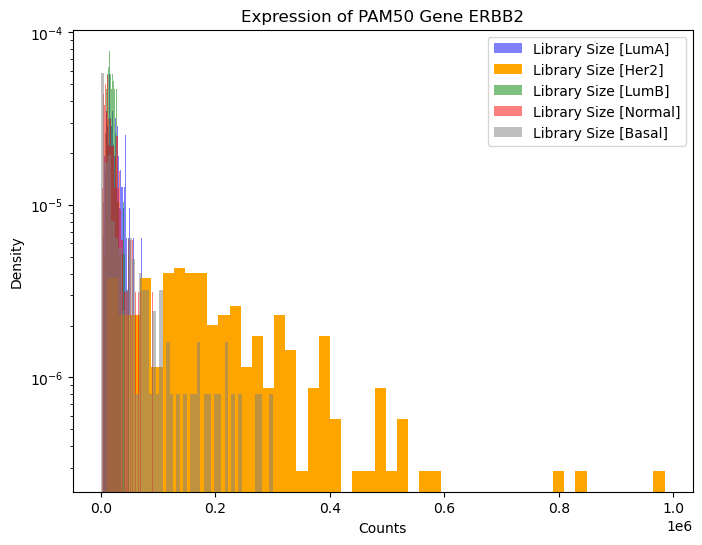

In [11]:
# check a gene to show this is working; ERBB2 seems like the obvious choice
gene_of_interest = 'ERBB2'

gene_index = np.where(adata_train.var_names == gene_of_interest)[0][0]
gene_expression = adata_train.X[:, gene_index]


subtypes = adata_train.obs['subtype']
library_sizes_luma = gene_expression[subtypes == "luma"]
library_sizes_her2 = gene_expression[subtypes == "her2"]
library_sizes_lumb = gene_expression[subtypes == "lumb"]
library_sizes_normal = gene_expression[subtypes == "normal"]
library_sizes_basal = gene_expression[subtypes == "basal"]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_luma, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [LumA]')
plt.hist(library_sizes_her2, bins=50, density=True, alpha=1, color='orange', label='Library Size [Her2]')
plt.hist(library_sizes_lumb, bins=50, density=True, alpha=0.5, color='green', label='Library Size [LumB]')
plt.hist(library_sizes_normal, bins=50, density=True, alpha=0.5, color='red', label='Library Size [Normal]')
plt.hist(library_sizes_basal, bins=50, density=True, alpha=0.5, color='grey', label='Library Size [Basal]')
plt.title('Expression of PAM50 Gene ' + str(gene_of_interest))
plt.xlabel('Counts')
plt.ylabel('Density')
plt.yscale('log')  # Use a log scale for the y-axis
#plt.xscale('log')
plt.legend()
plt.show()

# no clear differenc

In [ ]:
# I want to load in dataset_subtype_3 and make a new version with a "jumbled" edge matrix

path = '/data/lab_vm/refined/preffect/0_synthetic_data/anndata/main_synthetic/dataset_subtype_3/train/'

import os
import anndata as ad

def load_anndata_from_directory(directory_path):
    # List all files in the directory
    files = os.listdir(directory_path)
    
    # Find the first .h5ad file
    for file in files:
        if file.endswith('.h5ad'):
            file_path = os.path.join(directory_path, file)
            print(f"Loading AnnData file: {file_path}")
            adata = ad.read_h5ad(file_path)
            return adata
    
    raise FileNotFoundError("No AnnData (.h5ad) files found in the specified directory.")

adata = load_anndata_from_directory(path)

# You can now access the data in `adata`

orig_edge_matrix = adata.obsm['sample_sample_adj']
print(orig_edge_matrix)

In [13]:
edge_matrix = coo_matrix(orig_edge_matrix)
sample_minibatch_idx = [12, 913, 152, 886, 718, 619, 525, 850, 338, 825,  55, 447, 113, 225, 298, 312, 835, 606, 941, 436]

mask = np.isin(edge_matrix.row, sample_minibatch_idx) & np.isin(edge_matrix.col, sample_minibatch_idx)

# Extract the matching entries
matching_rows = edge_matrix.row[mask]
matching_cols = edge_matrix.col[mask]
matching_data = edge_matrix.data[mask]

count = 0
for r, c, d in zip(matching_rows, matching_cols, matching_data):
    print(f"Row: {r}, Column: {c}, Data: {d}")
    count += 1

print(count)
# yeah it's working

Row: 12, Column: 12, Data: 1
Row: 152, Column: 12, Data: 1
Row: 225, Column: 12, Data: 1
Row: 312, Column: 12, Data: 1
Row: 850, Column: 12, Data: 1
Row: 55, Column: 55, Data: 1
Row: 338, Column: 55, Data: 1
Row: 436, Column: 55, Data: 1
Row: 113, Column: 113, Data: 1
Row: 525, Column: 113, Data: 1
Row: 12, Column: 152, Data: 1
Row: 152, Column: 152, Data: 1
Row: 225, Column: 152, Data: 1
Row: 312, Column: 152, Data: 1
Row: 850, Column: 152, Data: 1
Row: 12, Column: 225, Data: 1
Row: 152, Column: 225, Data: 1
Row: 225, Column: 225, Data: 1
Row: 312, Column: 225, Data: 1
Row: 850, Column: 225, Data: 1
Row: 298, Column: 298, Data: 1
Row: 619, Column: 298, Data: 1
Row: 913, Column: 298, Data: 1
Row: 12, Column: 312, Data: 1
Row: 152, Column: 312, Data: 1
Row: 225, Column: 312, Data: 1
Row: 312, Column: 312, Data: 1
Row: 850, Column: 312, Data: 1
Row: 55, Column: 338, Data: 1
Row: 338, Column: 338, Data: 1
Row: 436, Column: 338, Data: 1
Row: 55, Column: 436, Data: 1
Row: 338, Column: 436, 

In [115]:
# Structure of edge matrix
# (0, 0)	1
#  (4, 0)	1
# keep diagonals, but jumble the rest; just change the first number

edge_matrix = coo_matrix(orig_edge_matrix)
matrix_size = adata.n_obs

non_diag_mask = edge_matrix.row != edge_matrix.col
non_diag_rows = edge_matrix.row[non_diag_mask]
non_diag_cols = edge_matrix.col[non_diag_mask]
non_diag_data = edge_matrix.data[non_diag_mask]

# Function to find a valid random offset
def find_valid_offset(row_value, col_value, matrix_size):
    while True:
        offset = np.random.randint(1, 6) * np.random.choice([-1, 1])
        new_row_value = row_value + offset
        # Ensure it does not create a diagonal or go out of bounds
        if new_row_value != col_value and 0 <= new_row_value < matrix_size:
            return new_row_value

# Apply random offset to non-diagonal row indices
adjusted_rows = np.array([
    find_valid_offset(row, col, matrix_size)
    for row, col in zip(non_diag_rows, non_diag_cols)
])

# Create a new matrix with adjusted non-diagonal elements
adjusted_matrix = coo_matrix((non_diag_data, (adjusted_rows, non_diag_cols)), shape=(matrix_size, matrix_size))

# Add the diagonal elements back
diagonal_mask = edge_matrix.row == edge_matrix.col
diagonal_rows = edge_matrix.row[diagonal_mask]
diagonal_cols = edge_matrix.col[diagonal_mask]
diagonal_data = edge_matrix.data[diagonal_mask]

# Combine the adjusted non-diagonal and original diagonal elements
final_matrix = coo_matrix(
    (np.concatenate([adjusted_matrix.data, diagonal_data]),
     (np.concatenate([adjusted_matrix.row, diagonal_rows]),
      np.concatenate([adjusted_matrix.col, diagonal_cols]))),
    shape=(matrix_size, matrix_size)
)

# Convert to CSR format for efficient arithmetic operations

print(np.sum(edge_matrix.col == 0), np.sum(final_matrix.col == 0))

final_matrix_csr = final_matrix.tocsr()


column_zero_mask = final_matrix.col == 0
rows_with_col_zero = final_matrix.row[column_zero_mask]
data_with_col_zero = final_matrix.data[column_zero_mask]

# Print the entries
for r, d in zip(rows_with_col_zero, data_with_col_zero):
    print(f"Row: {r}, Column: 0, Data: {d}")




205 205
Row: 5, Column: 0, Data: 1
Row: 3, Column: 0, Data: 1
Row: 9, Column: 0, Data: 1
Row: 14, Column: 0, Data: 1
Row: 15, Column: 0, Data: 1
Row: 10, Column: 0, Data: 1
Row: 11, Column: 0, Data: 1
Row: 15, Column: 0, Data: 1
Row: 29, Column: 0, Data: 1
Row: 22, Column: 0, Data: 1
Row: 24, Column: 0, Data: 1
Row: 34, Column: 0, Data: 1
Row: 36, Column: 0, Data: 1
Row: 47, Column: 0, Data: 1
Row: 52, Column: 0, Data: 1
Row: 55, Column: 0, Data: 1
Row: 67, Column: 0, Data: 1
Row: 76, Column: 0, Data: 1
Row: 71, Column: 0, Data: 1
Row: 79, Column: 0, Data: 1
Row: 87, Column: 0, Data: 1
Row: 89, Column: 0, Data: 1
Row: 89, Column: 0, Data: 1
Row: 94, Column: 0, Data: 1
Row: 99, Column: 0, Data: 1
Row: 105, Column: 0, Data: 1
Row: 100, Column: 0, Data: 1
Row: 116, Column: 0, Data: 1
Row: 114, Column: 0, Data: 1
Row: 112, Column: 0, Data: 1
Row: 123, Column: 0, Data: 1
Row: 117, Column: 0, Data: 1
Row: 128, Column: 0, Data: 1
Row: 145, Column: 0, Data: 1
Row: 145, Column: 0, Data: 1
Row: 

In [116]:
# This method is working but it creates repeat edges. Lets identify them and +1 them.
dense_matrix = final_matrix.toarray()

# Identify duplicates and increment row index
unique_entries = set()
new_rows = []
new_cols = []
new_data = []

for r, c, d in zip(final_matrix.row, final_matrix.col, final_matrix.data):
    entry = (r, c)
    if entry in unique_entries:
        # Increment the row index if it's a duplicate
        new_row = r + 1
        # Ensure the new row index is within bounds
        if new_row < matrix_size:
            new_rows.append(new_row)
            new_cols.append(c)
            new_data.append(d)
    else:
        unique_entries.add(entry)
        new_rows.append(r)
        new_cols.append(c)
        new_data.append(d)

# Create a new matrix with updated rows
updated_matrix = coo_matrix((new_data, (new_rows, new_cols)), shape=(matrix_size, matrix_size))

# Convert to CSR format for efficient arithmetic operations
updated_matrix_csr = updated_matrix.tocsr()

# Print the updated matrix

column_zero_mask = updated_matrix.col == 0
rows_with_col_zero = updated_matrix.row[column_zero_mask]
data_with_col_zero = updated_matrix.data[column_zero_mask]

# Print the entries
for r, d in zip(rows_with_col_zero, data_with_col_zero):
    print(f"Row: {r}, Column: 0, Data: {d}")





Row: 5, Column: 0, Data: 1
Row: 3, Column: 0, Data: 1
Row: 9, Column: 0, Data: 1
Row: 14, Column: 0, Data: 1
Row: 15, Column: 0, Data: 1
Row: 10, Column: 0, Data: 1
Row: 11, Column: 0, Data: 1
Row: 16, Column: 0, Data: 1
Row: 29, Column: 0, Data: 1
Row: 22, Column: 0, Data: 1
Row: 24, Column: 0, Data: 1
Row: 34, Column: 0, Data: 1
Row: 36, Column: 0, Data: 1
Row: 47, Column: 0, Data: 1
Row: 52, Column: 0, Data: 1
Row: 55, Column: 0, Data: 1
Row: 67, Column: 0, Data: 1
Row: 76, Column: 0, Data: 1
Row: 71, Column: 0, Data: 1
Row: 79, Column: 0, Data: 1
Row: 87, Column: 0, Data: 1
Row: 89, Column: 0, Data: 1
Row: 90, Column: 0, Data: 1
Row: 94, Column: 0, Data: 1
Row: 99, Column: 0, Data: 1
Row: 105, Column: 0, Data: 1
Row: 100, Column: 0, Data: 1
Row: 116, Column: 0, Data: 1
Row: 114, Column: 0, Data: 1
Row: 112, Column: 0, Data: 1
Row: 123, Column: 0, Data: 1
Row: 117, Column: 0, Data: 1
Row: 128, Column: 0, Data: 1
Row: 145, Column: 0, Data: 1
Row: 146, Column: 0, Data: 1
Row: 148, Col

In [125]:
# lets do it again if that shift caused new non-unique combinations

dense_matrix = updated_matrix.toarray()

# Identify duplicates and increment row index
unique_entries = set()
new_rows = []
new_cols = []
new_data = []

for r, c, d in zip(updated_matrix.row, updated_matrix.col, updated_matrix.data):
    entry = (r, c)
    if entry in unique_entries:
        # Increment the row index if it's a duplicate
        new_row = r + 1
        # Ensure the new row index is within bounds
        if new_row < matrix_size:
            new_rows.append(new_row)
            new_cols.append(c)
            new_data.append(d)
    else:
        unique_entries.add(entry)
        new_rows.append(r)
        new_cols.append(c)
        new_data.append(d)

# Create a new matrix with updated rows
updated_matrix = coo_matrix((new_data, (new_rows, new_cols)), shape=(matrix_size, matrix_size))

# Convert to CSR format for efficient arithmetic operations
updated_matrix_csr = updated_matrix.tocsr()

# Print the updated matrix

column_zero_mask = updated_matrix.col == 0
rows_with_col_zero = updated_matrix.row[column_zero_mask]
data_with_col_zero = updated_matrix.data[column_zero_mask]

# Print the entries
for r, d in zip(rows_with_col_zero, data_with_col_zero):
    print(f"Row: {r}, Column: 0, Data: {d}")


Row: 5, Column: 0, Data: 1
Row: 3, Column: 0, Data: 1
Row: 9, Column: 0, Data: 1
Row: 14, Column: 0, Data: 1
Row: 15, Column: 0, Data: 1
Row: 10, Column: 0, Data: 1
Row: 11, Column: 0, Data: 1
Row: 16, Column: 0, Data: 1
Row: 29, Column: 0, Data: 1
Row: 22, Column: 0, Data: 1
Row: 24, Column: 0, Data: 1
Row: 34, Column: 0, Data: 1
Row: 36, Column: 0, Data: 1
Row: 47, Column: 0, Data: 1
Row: 52, Column: 0, Data: 1
Row: 55, Column: 0, Data: 1
Row: 67, Column: 0, Data: 1
Row: 76, Column: 0, Data: 1
Row: 71, Column: 0, Data: 1
Row: 79, Column: 0, Data: 1
Row: 87, Column: 0, Data: 1
Row: 89, Column: 0, Data: 1
Row: 90, Column: 0, Data: 1
Row: 94, Column: 0, Data: 1
Row: 99, Column: 0, Data: 1
Row: 105, Column: 0, Data: 1
Row: 100, Column: 0, Data: 1
Row: 116, Column: 0, Data: 1
Row: 114, Column: 0, Data: 1
Row: 112, Column: 0, Data: 1
Row: 123, Column: 0, Data: 1
Row: 117, Column: 0, Data: 1
Row: 128, Column: 0, Data: 1
Row: 145, Column: 0, Data: 1
Row: 146, Column: 0, Data: 1
Row: 148, Col

In [126]:
# count duplicates in 
from collections import Counter

entries = list(zip(updated_matrix.row, updated_matrix.col))

# Count occurrences of each entry
entry_counts = Counter(entries)

# Count how many entries have duplicates
duplicate_count = sum(1 for count in entry_counts.values() if count > 1)

print(f"The number of duplicate entries is: {duplicate_count}")

print("Duplicate entries (row, column) and their counts:")

# repeated the last two segments until duplicates == 0


The number of duplicate entries is: 0
Duplicate entries (row, column) and their counts:


In [ ]:

adata.obsm['sample_sample_adj'] = updated_matrix.tocsr()
adata.write('/path/to/output/dataset_subtype_jumbled/test/sim_simple_w_layers.sim_subtype.M_1000_N_1000_th_1_batch_bal_0.5_jumble.test.tau_1.h5ad')
